<a href="https://colab.research.google.com/github/AmirHesamKamalpour/Information-retrieval-system-based-on-tf-idf-using-bigrams-and-unigrams/blob/main/Information_retrieval_system_based_on_tf_idf_using_bigrams_and_unigrams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AmirHesam Kamalpour**

In [ ]:
pip install git+https://github.com/roshan-research/hazm.git

In [ ]:
!pip install python-bidi
!pip install --upgrade arabic-reshaper
!pip install -U sentence-transformers

In [ ]:
import pandas as pd
import string
from collections import defaultdict
from collections import Counter # not used
import matplotlib.pyplot as plt
from arabic_reshaper import reshape
from bidi.algorithm import get_display
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # not used
from nltk import ngrams
import numpy as np
from sentence_transformers import SentenceTransformer
import re
from hazm import *
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity as cs # used in KNN but has the same effect as cosine similarity that we have

In [ ]:
df = pd.read_csv("/content/crawl-result.csv").rename(columns={'Category': 'class', 'Description': 'text'})

In [ ]:
def vectorize_sentences(dataset, column, model_name='sentence-transformers/LaBSE'):

    df = dataset.copy()

    model = SentenceTransformer(model_name)

    def encode_sentence(sentence):
        return model.encode([sentence])[0]

    df['Vector'] = df[column].apply(encode_sentence)

    return df

In [ ]:
def calculate_tfidf(dataset, column, n = 1):

    tokenizer = WordTokenizer()
    tf_idf = {}
    N = dataset.shape[0]
    tokens_column = dataset[column].apply(tokenizer.tokenize)

    if n == 2:
      tokens_column = tokens_column.apply(lambda tokens: list(ngrams(tokens, n)))

    for index, tokens in tokens_column.iteritems():
        counter = Counter(tokens)
        words_count = len(tokens)
        unique_tokens = set(tokens)

        for token in unique_tokens:
            tf = counter[token] / words_count
            df = dic2.get(token, 0) if n == 2 else dic.get(token, 0)

            idf = np.log((N + 1) / (df + 1))

            tf_idf[index, token] = tf * idf

    return tf_idf

In [ ]:
def vectorize_query(query, terms, tfidf_matrix_shape, n = 1):

    tokenizer = WordTokenizer()
    tokens = tokenizer.tokenize(query)
    tfidf_vector = np.zeros(len(terms))

    if n == 2:
      tokens = list(ngrams(tokens, 2))

    counter = Counter(tokens)
    words_count = len(tokens)
    unique_tokens = set(tokens)

    for token in unique_tokens:
        tf = counter[token] / words_count
        df = dic2.get(token, 0) if n == 2 else dic.get(token, 0)
        idf = np.log((tfidf_matrix_shape[0] + 1) / (df + 1))

        if token in terms:
            term_idx = terms.index(token)
            tfidf_vector[term_idx] = tf * idf

    return tfidf_vector

In [ ]:
def cosine_similarity(vector1, vector2):
  dot_product = np.einsum('i,i', vector1, vector2)
  norm1 = np.linalg.norm(vector1)
  norm2 = np.linalg.norm(vector2)
  return dot_product / (norm1 * norm2) if norm1 * norm2 != 0 else 0

In [ ]:
def compute_cosine_similarity_query(query_vector, tfidf_matrix):

    similarity_scores = []

    for i in range(tfidf_matrix.shape[0]):
        similarity_scores.append(cosine_similarity(query_vector, tfidf_matrix[i]))

    return similarity_scores

In [ ]:
def get_top_similar_results(N_closest, query_similarity_scores, output_file):

    top_similar_indices = sorted(range(len(query_similarity_scores)), key=lambda i: query_similarity_scores[i], reverse=True)[:N_closest]
    top_similar_scores = sorted(query_similarity_scores, reverse=True)[:N_closest]

    result_df = pd.DataFrame({'Document_Index': top_similar_indices, 'Similarity_Score': top_similar_scores})

    result_df.to_csv(output_file, index=False)

    return result_df

In [ ]:
def jaccard_coefficient(query_tokens, doc_tokens, n) -> float:

  union_of_words = set(doc_tokens).union(set(query_tokens))
  union_length = len(union_of_words)

  intersection_of_sentences = len(set(query_tokens)) + len(set(doc_tokens)) - union_length

  return intersection_of_sentences / union_length

In [ ]:
def compute_jaccard_coefficient_similarity_query(query, dataset, n = 1):

  tokenizer = WordTokenizer()
  query_tokens = set(tokenizer.tokenize(query))
  similarity_scores = []
  if n == 2:
    query_tokens = list(ngrams(query_tokens, 2))

  for _, row in dataset.iterrows():
    doc_tokens = set(tokenizer.tokenize(row['text']))
    if n == 2:
      doc_tokens = list(ngrams(doc_tokens, 2))
    similarity_scores.append(jaccard_coefficient(query_tokens, doc_tokens, n))

  return similarity_scores

In [ ]:
def k_nearest_neighbors(query_text):
  nn = NearestNeighbors(n_neighbors=10, metric='cosine')

  nn.fit(unary_tfidf_matrix)

  query = vectorize_query(preprocess_query(query_text), unary_terms, unary_tfidf_matrix.shape, 1)
  distances, indices = nn.kneighbors(query.reshape(1, -1))

  nearest_distances = distances[0]
  nearest_indices = indices[0]

  data = []

  for distance, index in zip(nearest_distances, nearest_indices):
      #similarity_score = cs(query.reshape(1, -1), unary_tfidf_matrix[index].reshape(1, -1))[0][0]
      data.append({
          'Index': index,
          #'Similarity': similarity_score,
          'Distance': distance
      })

  new_df = pd.DataFrame(data)

  new_df.to_csv("K_Nearest_Neighbours_Results", index=False)

  return new_df

In [ ]:
def plot_most_repeated_words(sorted_dict, number):

  words = list(sorted_dict.keys())[:number]
  counts = list(sorted_dict.values())[:number]

  persian_words = [get_display(reshape(word)) for word in words]

  plt.figure(figsize=(10, 6))
  plt.bar(persian_words, counts)
  plt.xticks(rotation=90)
  plt.xlabel('Words')
  plt.ylabel('Counts')
  plt.title(f'Top {number} Words')
  plt.tight_layout()
  plt.show()

# Preprocessing Dataset

In [ ]:
def build_vocabulary_dataset(dataset, column: string) -> dict :

  all_text = ' '.join(dataset[column].astype(str))
  tokenizer = WordTokenizer()
  words = tokenizer.tokenize(all_text)
  word_counts = Counter(words)
  word_counts_dict = dict(word_counts)

  with open('vocabulary.txt', 'w') as file:
    for word, count in word_counts.items():
        file.write(f"{word}: {count} times\n")

  return word_counts_dict

In [ ]:
def build_bigram_vocabulary_dataset(dataset, column):

    all_text = ' '.join(dataset[column].astype(str))
    tokenizer = WordTokenizer()
    tokens = tokenizer.tokenize(all_text)
    bigrams = list(ngrams(tokens, 2))

    word_counts = Counter(bigrams)
    word_counts_dict = dict(word_counts)

    with open('vocabulary_bigram.txt', 'w') as file:
        for word, count in word_counts.items():
            file.write(f"{word}: {count} times\n")

    return word_counts_dict

In [ ]:
def remove_stop_words_dataset(dataset, column: string):

  stop_words = stopwords_list()
  pat = r'\b(?:{})\b'.format('|'.join(stop_words))
  dataset[column] = dataset[column].str.replace(pat, '')
  dataset[column] = dataset[column].str.replace(r'\s+', ' ')

  return dataset

In [ ]:
def remove_stop_words_query(query):

  stop_words = stopwords_list()
  new_query = ' '.join([word for word in query.split() if word not in stop_words])

  return new_query

In [ ]:
def preprocess_dataset(dataframe, column: str, normalization : bool = True, stopword_removal: bool = True, stemming: bool = True):

  to_replace = ['-', '.', '،', ':', '«', '»', '(', ')', '؛',"!", '?', '؟', '\u200c']
  processed_df = dataframe.copy()

  for substring in to_replace:
    processed_df[column] = processed_df[column].str.replace(substring, ' ')

  processed_df[column] = processed_df[column].apply(lambda x: re.sub(r'.*ایرنا\b', '', x))

  normalizer = Normalizer()
  stemmer = Stemmer()

  if normalization is True:
    processed_df[column] = processed_df[column].apply(normalizer.normalize)

  if stopword_removal is True:
    processed_df = remove_stop_words_dataset(processed_df, column)

  if stemming is True:
    processed_df[column] = processed_df[column].apply(stemmer.stem)

  processed_df.drop_duplicates(subset=[column], keep= 'first', inplace = True)

  return processed_df.reset_index(drop = True)

In [ ]:
def preprocess_query(query, normalization : bool = True, stopword_removal: bool = True, stemming: bool = True):

  normalizer = Normalizer()
  stemmer = Stemmer()

  if normalization is True:
    query = normalizer.normalize(query)

  if stopword_removal is True:
    query = remove_stop_words_query(query)

  if stemming is True:
    query = stemmer.stem(query)

  return query

In [ ]:
def calculate_preliminaries(dataframe, column, n):

  tfidf_values = calculate_tfidf(dataframe, 'text', n)
  terms = sorted(list(set([key[1] for key in tfidf_values.keys()])))
  tfidf_matrix = np.zeros((dataframe.shape[0], len(terms)))

  for (doc_idx, term), value in tfidf_values.items():
    term_idx = terms.index(term)
    tfidf_matrix[doc_idx, term_idx] = value

  return terms, tfidf_matrix

In [ ]:
def test_unigram(query_text):
  query_vector = vectorize_query(preprocess_query(query_text), unary_terms, unary_tfidf_matrix.shape, 1)
  query_similarity_scores = compute_cosine_similarity_query(query_vector, unary_tfidf_matrix)
  return get_top_similar_results(10, query_similarity_scores, "Unigram_Results.csv")

In [ ]:
def test_bigram(query_text):
  query_vector = vectorize_query(preprocess_query(query_text), binary_terms, binary_tdidf_matrix.shape, 2)
  query_similarity_scores = compute_cosine_similarity_query(query_vector, binary_tdidf_matrix)
  return get_top_similar_results(10, query_similarity_scores, 'Bigram_Results.csv')

In [ ]:
def test_jaccard(query_text, n):
  if n == 2:
    jaccard_similarity = compute_jaccard_coefficient_similarity_query(preprocess_query(query_text), processed_df, 2)
    return get_top_similar_results(5, jaccard_similarity,'Jaccard_Bigram_Results.csv')

  elif n==1:
    jaccard_similarity = compute_jaccard_coefficient_similarity_query(preprocess_query(query_text), processed_df, 1)
    return get_top_similar_results(5, jaccard_similarity,'Jaccard_Results.csv')

<ipython-input-18-6ddfee5b8eba>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  processed_df[column] = processed_df[column].str.replace(substring, ' ')
<ipython-input-16-06b7f6670646>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset[column] = dataset[column].str.replace(pat, '')
<ipython-input-16-06b7f6670646>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset[column] = dataset[column].str.replace(r'\s+', ' ')


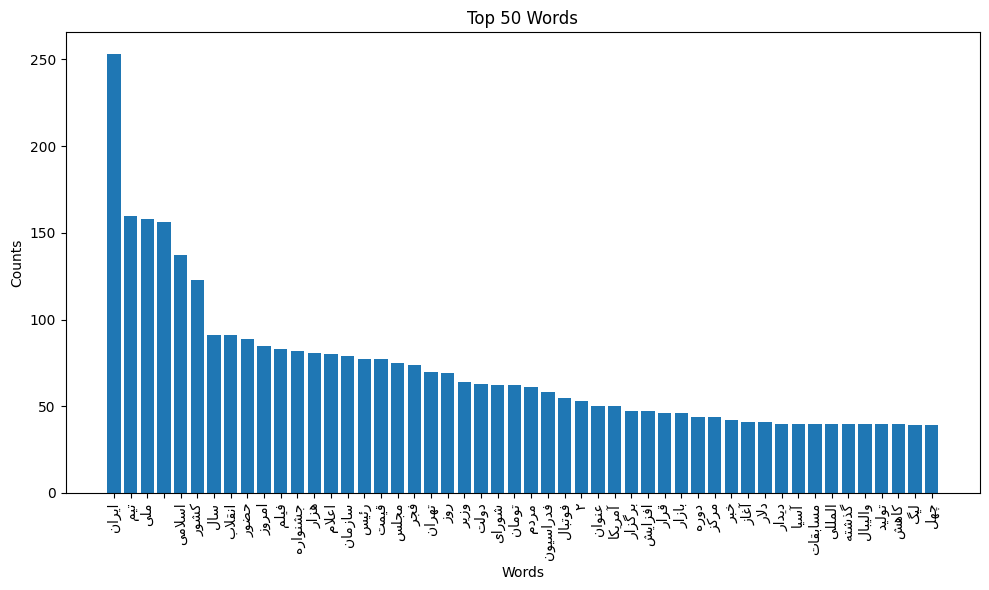

In [ ]:
processed_df = preprocess_dataset(df, 'text')
dic = build_vocabulary_dataset(processed_df, 'text')
dic2 = build_bigram_vocabulary_dataset(processed_df, 'text')
sorted_dict = dict(sorted(dic.items(), key=lambda item: item[1], reverse=True))
plot_most_repeated_words(sorted_dict, 50)

In [ ]:
unary_terms, unary_tfidf_matrix = calculate_preliminaries(processed_df, 'text', 1)
binary_terms, binary_tdidf_matrix = calculate_preliminaries(processed_df, 'text', 2)

<ipython-input-5-1f1174a6c456>:11: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, tokens in tokens_column.iteritems():


In [ ]:
query1 = input("Enter the query: ")

In [ ]:
query1 = 'معاون وزیر خارجه دولت صنعا موضع عربستان سعودی در عدم همراهی با اعتلاف امریکایی در دریای سرخ را شجاعانه خواهند و از آن تقدیر کرد'

In [ ]:
test_bigram(query1)

,Document_Index,Similarity_Score
0,153,0.201795
1,816,0.166977
2,666,0.155026
3,309,0.139633
4,889,0.137992
5,817,0.130667
6,299,0.125386
7,660,0.111704
8,787,0.087182
9,0,0.000000


In [ ]:
test_unigram(query1)

,Document_Index,Similarity_Score
0,816,0.235673
1,153,0.187665
2,817,0.178875
3,660,0.175132
4,455,0.153862
5,264,0.140355
6,666,0.138006
7,648,0.134148
8,708,0.131167
9,737,0.118511


In [ ]:
test_jaccard(query1, 1)

,Document_Index,Similarity_Score
0,153,0.090909
1,321,0.083333
2,708,0.080000
3,309,0.076923
4,889,0.074074


In [ ]:
test_jaccard(query1, 2)

,Document_Index,Similarity_Score
0,817,0.033333
1,816,0.025641
2,0,0.000000
3,1,0.000000
4,2,0.000000


In [ ]:
k_nearest_neighbors(query1)

,Index,Distance
0,816,0.764327
1,153,0.812335
2,817,0.821125
3,660,0.824868
4,455,0.846138
5,264,0.859645
6,666,0.861994
7,648,0.865852
8,708,0.868833
9,737,0.881489
